Tuesday Challenge #2: Raster where aspect is classified into North and South facing slopes


In [1]:
%pwd

'/Users/amylangston/Dropbox/NEON_2017'

In [3]:
cd '/Users/amylangston/Dropbox/NEON_2017/Day_2_lidar'

/Users/amylangston/Dropbox/NEON_2017/Day_2_lidar


In [2]:
import numpy as np
import gdal
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Use neon_aop_lidar_raster_functions.py to use raster2array:

In [9]:
# %load neon_aop_lidar_raster_functions.py
import gdal, osr 
import numpy as np

def raster2array(geotif_file):
    
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()
    
    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]
    
    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])
    
    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()
        
        # band statistics
        metadata['bandstats'] = {} #make a nested dictionary to store band stats in same 
        stats = raster.GetStatistics(True,True)
        metadata['bandstats']['min'] = round(stats[0],2)
        metadata['bandstats']['max'] = round(stats[1],2)
        metadata['bandstats']['mean'] = round(stats[2],2)
        metadata['bandstats']['stdev'] = round(stats[3],2)
        
        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        array[array==metadata['noDataValue']]=np.nan
        array = array/metadata['scaleFactor']
        array = array[::-1] #inverse array because Python is column major
        return array, metadata
    
    elif metadata['bands'] > 1:
        print('More than one band ... need to modify function for case of multiple bands')
        
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,epsg):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

In [6]:
#this is the TEAK file for the challenge:
TEAK_aspect_tif = '../data/TEAK/lidar/2013_TEAK_1_326000_4103000_DTM_aspect.tif'


In [16]:
TEAK_dataset = gdal.Open(TEAK_aspect_tif)

cols = chm_dataset.RasterXSize; print('# of columns:', cols)
rows = chm_dataset.RasterYSize; print('# of rows:', rows)

# of columns: 1000
# of rows: 1000


In [10]:
#because I read in the neon_aop_lidar_raster_functions.py, now the raster2array will work. yay.
TEAK_asp_array, TEAK_asp_metadata = raster2array(TEAK_aspect_tif)

In [11]:
#let's use a for loop to look at the metadata:

for item in sorted(TEAK_asp_metadata):
    print(item + ':', TEAK_asp_metadata[item])

array_cols: 1000
array_rows: 1000
bands: 1
bandstats: {'mean': 115.59, 'min': 0.0, 'stdev': 66.57, 'max': 359.99}
driver: GeoTIFF
ext_dict: {'yMax': 4104000.0, 'xMin': 326000.0, 'xMax': 327000.0, 'yMin': 4103000.0}
extent: (326000.0, 327000.0, 4103000.0, 4104000.0)
geotransform: (326000.0, 1.0, 0.0, 4104000.0, 0.0, -1.0)
noDataValue: -9999.0
pixelHeight: -1.0
pixelWidth: 1.0
projection: PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","32611"]]
scaleFactor: 1.0


In [17]:
#define the spatial extent:

TEAK_mapinfo = TEAK_dataset.GetGeoTransform()
xMin = TEAK_mapinfo[0]
yMax = TEAK_mapinfo[3]

#calculate xMax and yMin
xMax = xMin + cols/TEAK_mapinfo[1]
yMin = yMax + rows/TEAK_mapinfo[5]

TEAK_ext = (xMin,xMax, yMin, yMax)
print('TEAK raster extent:', TEAK_ext)

TEAK raster extent: (326000.0, 327000.0, 4103000.0, 4104000.0)


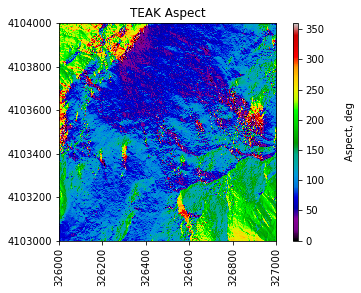

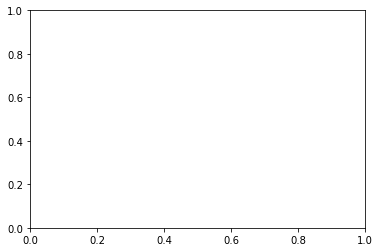

In [19]:
#copied in plot_band_array code from lesson1 tutorial that we used for CHM raster;
#couldn't run the plot_band_array code  in line 20 without it.

#plot
def plot_band_array(band_array,refl_extent,colorlimit,ax=plt.gca(),title='',cbar ='on',cmap_title='',colormap='spectral'):
    plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20);
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees

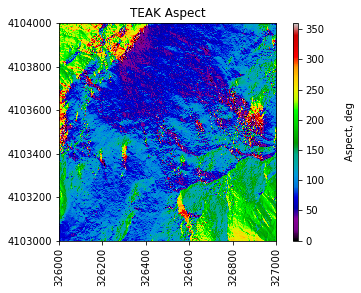

In [21]:
plot_band_array(TEAK_asp_array,TEAK_asp_metadata['extent'],(0,360),title='TEAK Aspect',cmap_title='Aspect, deg')

In [23]:
#look at histogram of data
import copy
#remove NaN values so histogram works
TEAK_nonan_array = copy.copy(TEAK_asp_array) #making a copy of data to preserve what we've already done(?)
TEAK_nonan_array = TEAK_nonan_array[~np.isnan(TEAK_asp_array)]

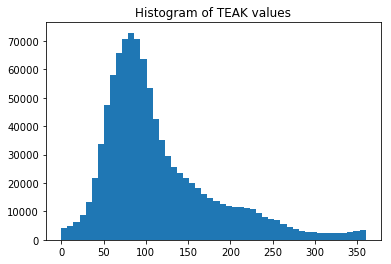

In [24]:
#histogram of TEAK_values with 50 bins
plt.hist(TEAK_nonan_array, bins=50); plt.title('Histogram of TEAK values')

In [25]:
#now we can classify

#classify raster based on north/south facing slopes
#copied in this code directly from challenge 

aspect_array = copy.copy(TEAK_asp_array)
asp_reclass = copy.copy(aspect_array)
asp_reclass[np.where(((aspect_array>=0) & (aspect_array<=45)) | (aspect_array>=315))] = 1 #North - Class 1
asp_reclass[np.where((aspect_array>=135) & (aspect_array<=225))] = 2 #South - Class 2
asp_reclass[np.where(((aspect_array>45) & (aspect_array<135)) | ((aspect_array>225) & (aspect_array<315)))] = np.nan #W & E - Unclassified


In [26]:
#copied in this code directly from challenge 
print('Min:',np.nanmin(asp_reclass))
print('Max:',np.nanmax(asp_reclass))
print('Mean:',round(np.nanmean(asp_reclass),2))

Min: 1.0
Max: 2.0
Mean: 1.7


In [27]:
#copied in this code directly from challenge 
# Scale plot 
def forceAspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

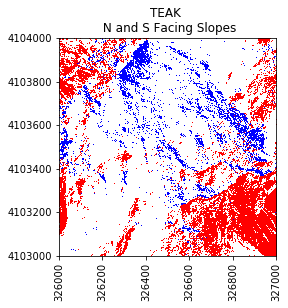

In [28]:
#copied in this code directly from challenge
# plot_band_array(aspect_reclassified,asp_ext,'North and South Facing Slopes \n TEAK')
from matplotlib import colors
fig, ax = plt.subplots()
cmapNS = colors.ListedColormap(['blue','red'])
plt.imshow(asp_reclass,extent=TEAK_asp_metadata['extent'],cmap=cmapNS)
plt.title('TEAK \n N and S Facing Slopes')
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees
ax = plt.gca(); forceAspect(ax,aspect=1)

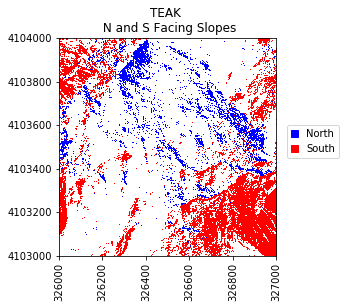

In [30]:
#yay, it worked! 
#now to polish it up:
#copied in this code directly from challenge

from matplotlib import colors
fig, ax = plt.subplots()
cmapNS = colors.ListedColormap(['blue','red'])
plt.imshow(asp_reclass,extent=TEAK_asp_metadata['extent'],cmap=cmapNS)
plt.title('TEAK \n N and S Facing Slopes')
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees
ax = plt.gca(); forceAspect(ax,aspect=1)

# Create custom legend to label N & S
import matplotlib.patches as mpatches
blue_box = mpatches.Patch(color='blue', label='North')
red_box = mpatches.Patch(color='red', label='South')
ax.legend(handles=[blue_box,red_box],handlelength=0.7,bbox_to_anchor=(1.05, 0.45), 
          loc='lower left', borderaxespad=0.)